In [ ]:
import numpy as np
from tqdm import tqdm
import torch
from PIL import Image
from cyber.models.world.autoencoder.cosmos_tokenizer.utils import *
from cyber.models.world.autoencoder import CausalVideoTokenizer

In [2]:
# DV model type
model_DV = "Cosmos-Tokenizer-DV4x8x8"

In [3]:
# load model
DV = CausalVideoTokenizer(checkpoint_enc=f'../checkpoints/{model_DV}/encoder.jit', checkpoint_dec=f'../checkpoints/{model_DV}/decoder.jit', dtype='bfloat16')

In [4]:
# read video and resize
filepath = 'demo_data/test_video.mp4'
video = read_video(filepath)
video = resize_video(video)

In [5]:
# set up window size
temporal_window = 17

### Encoding into discrete latent space for tokens

In [ ]:
# Encode the video using the Cosmos-Tokenizer-CV model
batch_video = video[np.newaxis, ...]
num_frames = batch_video.shape[1]
output_video_list = []
tokens_list = []
crop_regions = []

for idx in tqdm(range(0, (num_frames - 1) // temporal_window + 1)):
    # Input video for the current window.
    start, end = idx * temporal_window, (idx + 1) * temporal_window
    input_video = batch_video[:, start:end, ...]

    # Spatio-temporally pad input_video so it's evenly divisible.
    padded_input_video, crop_region = pad_video_batch(input_video)
    input_tensor = numpy2tensor(
        padded_input_video, dtype=torch.bfloat16, device="cuda"
    )

    tokens = DV.encode(input_tensor)[0] # discrete tokens: torch.Size([1, 5, 32, 32])
    tokens_list.append(tokens.squeeze(0)) # tokens: torch.Size([5, 32, 32])
    crop_regions.append(crop_region)

all_tokens = torch.cat(tokens_list, dim=0)
torch.save(all_tokens, "output/cosmos_tokens.pth")

In [ ]:
# Decode the tokens using the Cosmos-Tokenizer-DV model
tokens = torch.load("output/cosmos_tokens.pth")
output_video_list = []
num_windows = tokens.shape[0] // 5
for idx in tqdm(range(num_windows)):
    start_idx = idx * 5
    current_tokens = tokens[start_idx:start_idx + 5]
    current_tokens = current_tokens.unsqueeze(0)

    current_crop_region = crop_regions[idx]

    output_tensor = DV.decode(current_tokens)
    padded_output_video = tensor2numpy(output_tensor)
    output_video = unpad_video_batch(padded_output_video, current_crop_region)
    
    output_video_list.append(output_video)

result_video_DV = np.concatenate(output_video_list, axis=1)
write_video("output/recon_DV.mp4", result_video_DV[0], fps=30)

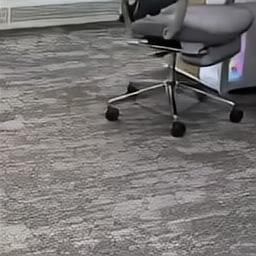

In [8]:
frame_DV = Image.fromarray(result_video_DV[0][0])
frame_DV

### Encoding into continuous latent space

In [9]:
# CV model type
model_CV = "Cosmos-Tokenizer-CV4x8x8"

In [13]:
# load model
CV = CausalVideoTokenizer(checkpoint_enc=f'../checkpoints/{model_CV}/encoder.jit', checkpoint_dec=f'../checkpoints/{model_CV}/decoder.jit', dtype='bfloat16')

In [ ]:
num_frames = batch_video.shape[1]
output_video_list = []
for idx in tqdm(range(0, (num_frames - 1) // temporal_window + 1)):
    # Input video for the current window.
    start, end = idx * temporal_window, (idx + 1) * temporal_window
    input_video = batch_video[:, start:end, ...]

    # Spatio-temporally pad input_video so it's evenly divisible.
    padded_input_video, crop_region = pad_video_batch(input_video)
    input_tensor = numpy2tensor(
        padded_input_video, dtype=torch.bfloat16, device="cuda"
    )

    tokens = CV.encode(input_tensor)[0] # continuous tokens: torch.Size([1, 16, 5, 32, 32])

    output_tensor = CV.decode(tokens)

    padded_output_video = tensor2numpy(output_tensor)
    output_video = unpad_video_batch(padded_output_video, crop_region)

    output_video_list.append(output_video)

result_video_CV = np.concatenate(output_video_list, axis=1)
write_video("output/recon_CV.mp4", result_video_CV[0], fps=30)

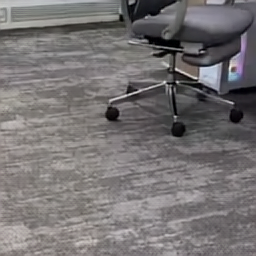

In [15]:
frame_CV = Image.fromarray(result_video_CV[0][0])
frame_CV